In [41]:
import pandas as pd

import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, f1_score 

from imblearn.over_sampling import SMOTE
from collections import Counter  

from sklearn.tree import DecisionTreeClassifier
import funciones

from feature_engine.discretisation import DecisionTreeDiscretiser

import pygad

import time

In [13]:
datos = pd.read_csv('/home/juan/proyectoTesis/datasets/creditcard.csv')

datos.shape

#Ver balanceo de la clase objetivo. Diabetes_012
porcentaje = 100*datos['Class'].value_counts()/len(datos)
print(porcentaje.astype(str) + '%')

Class
0       99.827251436938%
1    0.1727485630620034%
Name: count, dtype: object


In [14]:
#Discretizar caracteristicas por medio de arboles de decision
X = datos.drop("Class", axis=1)
y = datos["Class"]

columnas_disc = X.columns.to_list()

disc = DecisionTreeDiscretiser(bin_output="bin_number",
                                        cv=3,
                                        scoring="roc_auc",
                                        variables= columnas_disc, 
                                        regression=False)

disc.fit(X, y)

X_disc = disc.transform(X)


In [6]:
def fitness_mod(ga_instance, solution, solution_idx):
    # decodificar solucion 
    selected_features = []

    for i in range(len(solution)):
        
        if solution[i]==1:
            selected_features.append(columnas_disc[i])
    
    if not selected_features:
        return 0
        
    # Llamar a tasa_inconsistencia
    inconsistency_rate = funciones.tasa_inconsistencia(
        df=X_disc.join(y), 
        subconjunto_caracteristicas=selected_features, 
        clase='Class'
    )
    
    # Si inconsistency_rate es 0 (perfecto), el fitness sera maximo.
    fitness = 1.0 - inconsistency_rate
    
    return fitness

In [46]:
def callback_generation(ga_instance):
    current_time = time.time()

    duracion = current_time - ga_instance.last_execution_time

    best_solution, best_fitness, best_idx = ga_instance.best_solution()
    # Contamos el número de características (la suma de 1s en el cromosoma)
    num_caracteristicas = np.sum(best_solution)

    
    print(f"Generación : {ga_instance.generations_completed}")
    
    
    best_fitness = ga_instance.best_solution()[1]
    mejores_caracteristicas = []
    for i in range(len(best_solution)):
        if best_solution[i] == 1:
            mejores_caracteristicas.append(columnas_disc[i])
    print(f"Número de caracteristicas de la mejor solucion: {num_caracteristicas}")        
    print(f"Mejor Fitness : {best_fitness}")
    print("**************************************")
    print(f"Variables de la mejor solucion: {mejores_caracteristicas}")
    print("**************************************")
    print(f"Duración de la Generación : {duracion:.2f} segundos") 
    print("----------------")

    ga_instance.last_execution_time = current_time

In [47]:
#Algoritmo genetico para la seleccion de variables.
ga_instance = pygad.GA(
    num_generations=20,
    num_parents_mating=1, #numero de padres que seran seleccionados para reproducirse.
    parent_selection_type="tournament",
    K_tournament= 2,
    sol_per_pop=30,
    num_genes=len(X_disc.columns),
    gene_space=[0, 1],
    mutation_type="random",
    mutation_probability = 0.01,
    fitness_func=fitness_mod,
    save_solutions=True,
    on_generation=callback_generation
)


/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/pygad/pygad.py:1158: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


In [48]:
print("***********************Población inicial:**************************")
print(ga_instance.population)
print("*******************************************************************")

***********************Población inicial:**************************
[[1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1.
  1. 0. 1. 0. 1. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1.
  1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 1.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.
  0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0.
  0. 0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.
  0. 1. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1.
  1

In [49]:
#inicializar marca de tiempo
ga_instance.last_execution_time = time.time()

ga_instance.run()

Generación : 1
Número de caracteristicas de la mejor solucion: 18.0
Mejor Fitness : 0.9998349759661807
**************************************
Variables de la mejor solucion: ['Time', 'V1', 'V4', 'V7', 'V9', 'V10', 'V12', 'V14', 'V15', 'V16', 'V18', 'V20', 'V22', 'V23', 'V24', 'V26', 'V28', 'Amount']
**************************************
Duración de la Generación : 186.25 segundos
----------------
Generación : 2
Número de caracteristicas de la mejor solucion: 18.0
Mejor Fitness : 0.9998349759661807
**************************************
Variables de la mejor solucion: ['Time', 'V1', 'V4', 'V7', 'V9', 'V10', 'V12', 'V14', 'V15', 'V16', 'V18', 'V20', 'V22', 'V23', 'V24', 'V26', 'V28', 'Amount']
**************************************
Duración de la Generación : 90.14 segundos
----------------
Generación : 3
Número de caracteristicas de la mejor solucion: 18.0
Mejor Fitness : 0.9998349759661807
**************************************
Variables de la mejor solucion: ['Time', 'V1', 'V4', 'V7'

In [51]:
#Distribuciones de fitness de la ultima generacion

fitness_values = ga_instance.last_generation_fitness

fitness_values 

array([0.9998736 , 0.99986658, 0.99986658, 0.99986658, 0.99986658,
       0.99986658, 0.99986658, 0.99986658, 0.99986658, 0.99986658,
       0.99986658, 0.99986658, 0.99986658, 0.99986658, 0.99986658,
       0.99986658, 0.99986658, 0.99983849, 0.99986658, 0.99986658,
       0.99986658, 0.99986658, 0.99983146, 0.99986658, 0.99986658,
       0.99988062, 0.99986658, 0.99986658, 0.99986658, 0.99986658])

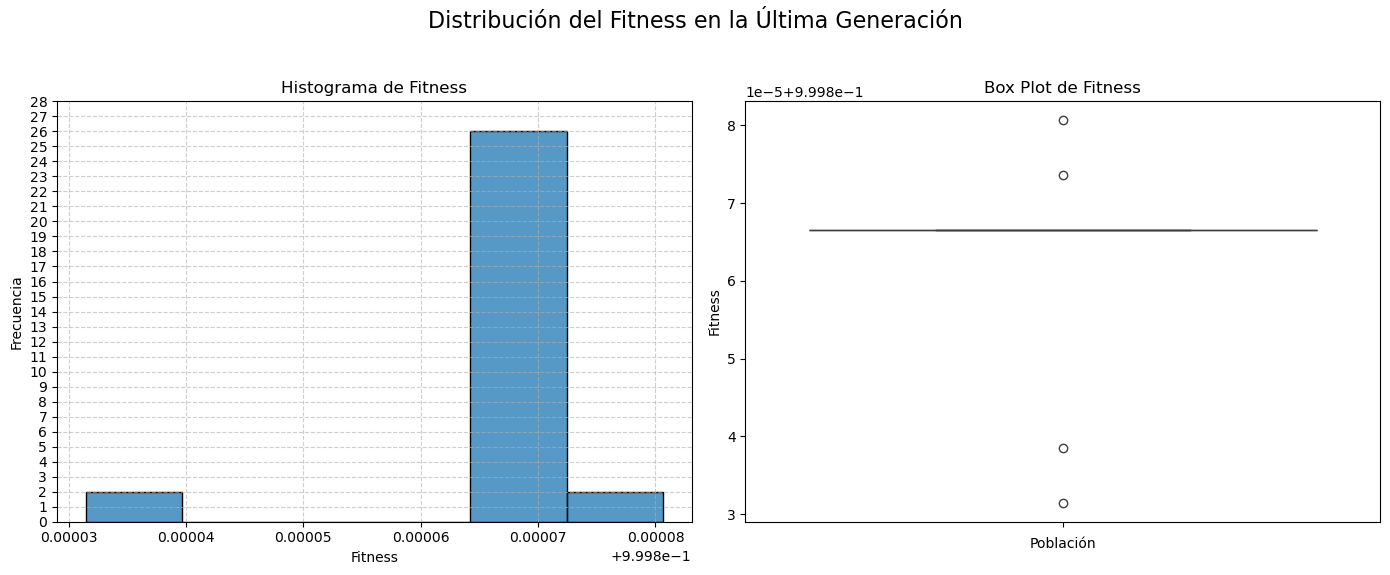

<Figure size 640x480 with 0 Axes>

In [52]:

import numpy
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Distribución del Fitness en la Última Generación', fontsize=16)

# Histograma
sns.histplot(fitness_values, ax=axes[0], kde=False)
axes[0].set_title('Histograma de Fitness')
axes[0].set_xlabel('Fitness')
y_max = axes[0].get_ylim()[1]
# Crear una lista de ticks de uno en uno, desde 0 hasta el máximo
y_ticks = numpy.arange(0, y_max + 1, 1)
axes[0].set_yticks(y_ticks)
# Establecer esos ticks en el eje Y del h
axes[0].set_ylabel('Frecuencia')
axes[0].ticklabel_format(style='plain', axis='x')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Box Plot
sns.boxplot(y=fitness_values, ax=axes[1])
axes[1].set_title('Box Plot de Fitness')
axes[1].set_xlabel('Población')
axes[1].set_ylabel('Fitness')


#guarda la figura.
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.savefig('fitness_distribution.png')

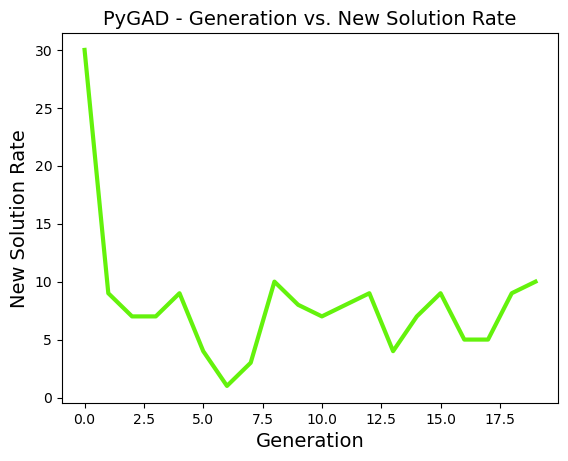

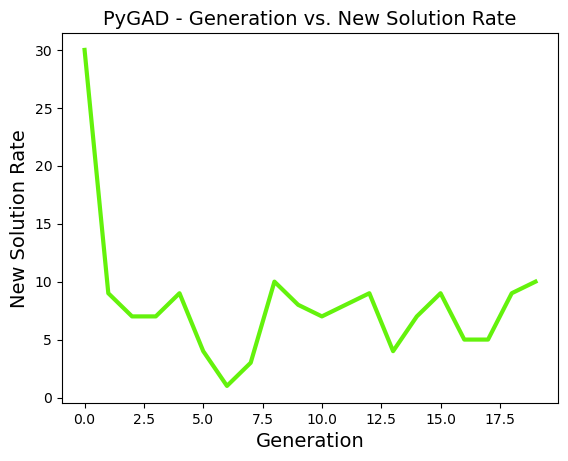

In [53]:
ga_instance.plot_new_solution_rate()